# Converting STLs to Voxels and Back

It turns out that creating a triangular mesh is quite a difficult task. Given our time constraints, it might be sensible to go down the more explored path of 3D object generation with voxels. Voxels can be thought of as "3D pixels". They are not as variable as triangular meshes and so are easier data objects to work with and much preexisting research is already available.

This notebook explores some of the utilities required in a voxel-based solution.

1. Converting STLs to Voxels
2. Converting Voxels to STLs

## Setup

In [2]:
import os
import numpy as np


# autoreload changed modules!!
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
# import data
import env
from data.thingi10k import Thingi10k
#from data.stl import save_vectors_as_stl
#from data.stl import plot_mesh

thingi = Thingi10k.init10()

## STL to Voxels

For this we need the binvox.exe program downloadable from http://www.patrickmin.com/binvox/

### Binvox Demonstration

In [5]:
import subprocess

stl_path = thingi.get_stl_path(0)
binvox_path = stl_path.replace('.stl', '.binvox')
subprocess.run(["../src/data/binvox", stl_path])
print(binvox_path, os.path.exists(binvox_path))

/home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/779964.binvox True


In [6]:
# the magical voxelization utility!
from data import binvox_rw

In [7]:
def read_3D(path):
    with open(path, 'rb') as f:
        m1 = binvox_rw.read_as_3d_array(f)
    return m1
    #return (np.reshape(downSampling.downsample_cube2(m1.data, 4), (32, 32, 32, 1)) - 0.5) / 0.5

In [8]:
vox = read_3D(binvox_path)
vox.data

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [9]:
# dimensions are 256 by 256; each voxel is represented by a TRUE in the array
vox.data.shape

(256, 256, 256)

In [12]:
np.reshape(vox.data, [256, 256, 256, 1]).shape

(256, 256, 256, 1)

In [13]:
vox.dims

[256, 256, 256]

### Controlling Voxel Object Dimension with Binvox

In [7]:
import subprocess

stl_path = thingi.get_stl_path(1)
binvox_path = stl_path.replace('.stl', '.binvox')
SIZE = 64
# binvox dim is controlled by -d arg
# -d: specify voxel grid size (default 256, max 1024)(no max when using -e)
subprocess.run(["../src/data/binvox", "-d", str(SIZE), stl_path])
print(binvox_path, os.path.exists(binvox_path))

# the magical voxelization utility!
from data import binvox_rw

def read_3D(path):
    with open(path, 'rb') as f:
        m1 = binvox_rw.read_as_3d_array(f)
    return m1
    #return (np.reshape(downSampling.downsample_cube2(m1.data, 4), (32, 32, 32, 1)) - 0.5) / 0.5
    
vox = read_3D(binvox_path)
vox.data.shape

/home/jcworkma/jack/3d-form/src/../data/external/Thingi10k/raw_meshes/1131717.binvox True


(64, 64, 64)

### Plotting a Binvox Object

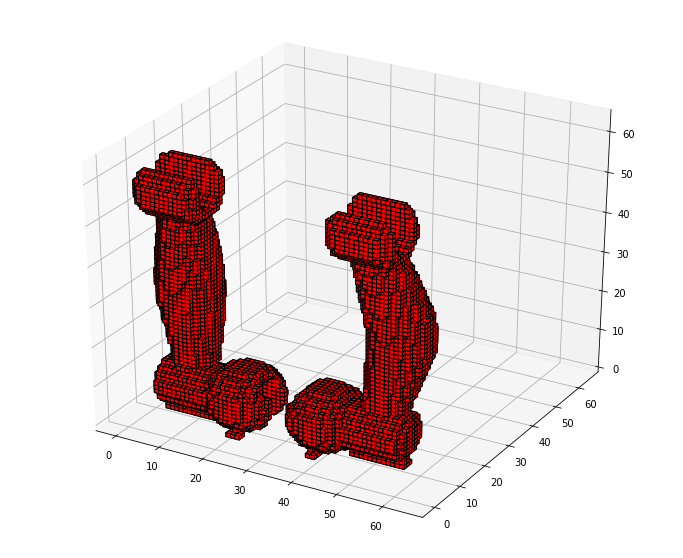

In [15]:
# https://matplotlib.org/gallery/mplot3d/voxels.html

# takes a really long time if dims are large

import matplotlib.pyplot as plt
import numpy as np

# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

fig = plt.figure(figsize=(12,10))
ax = fig.gca(projection='3d')
ax.voxels(vox.data, facecolors='red', edgecolor='k')

plt.show()

In [18]:
# there is a second func used to conserve memory
# hopefully this is not needed when we reduce dims
vox2 = None
with open(binvox_path, 'rb') as f:
    vox2 = binvox_rw.read_as_coord_array(f)
print(vox2.data.shape)
vox2.data

(3, 62603)


array([[1.22070312e-04, 1.37329102e-04, 1.52587891e-04, ...,
        2.55024521e+02, 2.55024536e+02, 2.55024551e+02],
       [8.00000000e+00, 9.00000000e+00, 1.00000000e+01, ...,
        7.10000000e+01, 7.20000000e+01, 7.30000000e+01],
       [3.12500000e-02, 3.51562500e-02, 3.90625000e-02, ...,
        6.27734375e+00, 6.28125000e+00, 6.28515625e+00]])

In [19]:
print(vox2.data[0].shape)

(62603,)


## Voxels to STLs

Using scikit learn's implementation of the "Marching Cubes" algorithm to convert voxels to a polygon mesh: http://scikit-image.org/docs/dev/auto_examples/edges/plot_marching_cubes.html#sphx-glr-auto-examples-edges-plot-marching-cubes-py

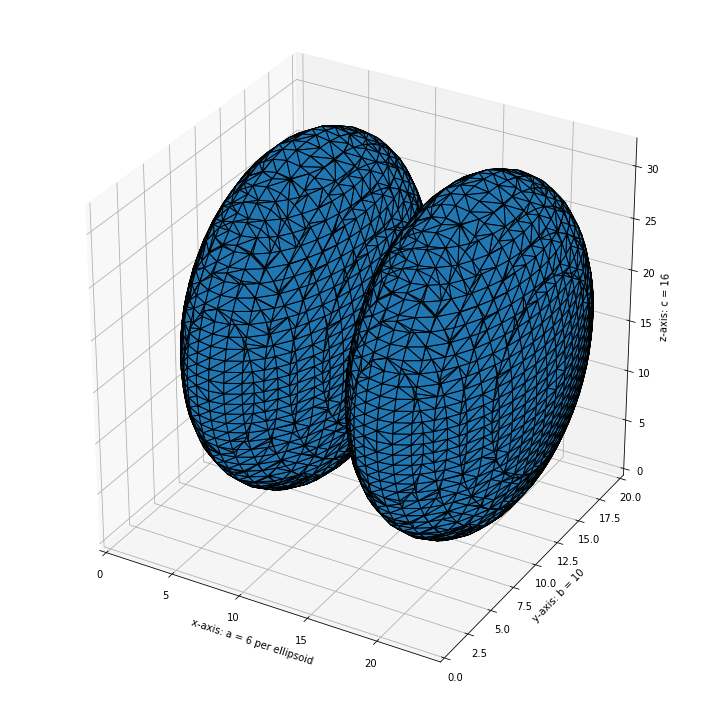

In [35]:
#
# This is an example from the abovel link not the voxels from the previous section
#

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure
from skimage.draw import ellipsoid


# Generate a level set about zero of two identical ellipsoids in 3D
ellip_base = ellipsoid(6, 10, 16, levelset=True)
ellip_double = np.concatenate((ellip_base[:-1, ...],
                               ellip_base[2:, ...]), axis=0)

# Use marching cubes to obtain the surface mesh of these ellipsoids
verts, faces, normals, values = measure.marching_cubes_lewiner(ellip_double, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 24)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 20)  # b = 10
ax.set_zlim(0, 32)  # c = 16

plt.tight_layout()
plt.show()

In [38]:
# what does the input to marching cubes look like?
print(ellip_double.shape)
ellip_double

(27, 23, 35)


array([[[2.70001736, 2.57111111, 2.45001736, ..., 2.45001736,
         2.57111111, 2.70001736],
        [2.49001736, 2.36111111, 2.24001736, ..., 2.24001736,
         2.36111111, 2.49001736],
        [2.30001736, 2.17111111, 2.05001736, ..., 2.05001736,
         2.17111111, 2.30001736],
        ...,
        [2.30001736, 2.17111111, 2.05001736, ..., 2.05001736,
         2.17111111, 2.30001736],
        [2.49001736, 2.36111111, 2.24001736, ..., 2.24001736,
         2.36111111, 2.49001736],
        [2.70001736, 2.57111111, 2.45001736, ..., 2.45001736,
         2.57111111, 2.70001736]],

       [[2.33890625, 2.21      , 2.08890625, ..., 2.08890625,
         2.21      , 2.33890625],
        [2.12890625, 2.        , 1.87890625, ..., 1.87890625,
         2.        , 2.12890625],
        [1.93890625, 1.81      , 1.68890625, ..., 1.68890625,
         1.81      , 1.93890625],
        ...,
        [1.93890625, 1.81      , 1.68890625, ..., 1.68890625,
         1.81      , 1.93890625],
        [2.1

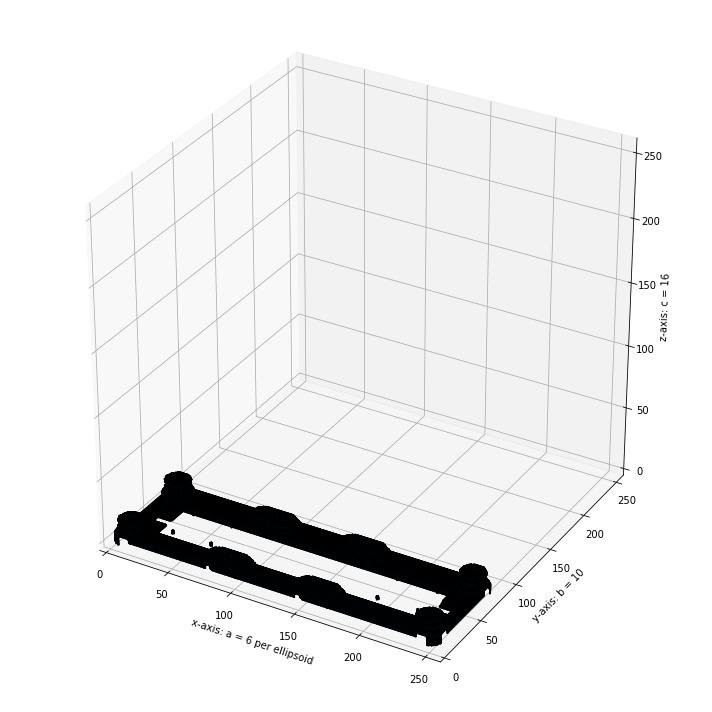

In [42]:
#
# trying now with voxel data as is
#

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

from skimage import measure

# Use marching cubes to obtain the surface mesh
verts, faces, normals, values = measure.marching_cubes_lewiner(vox.data, 0)

# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('k')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, vox.dims[0])
ax.set_ylim(0, vox.dims[1])
ax.set_zlim(0, vox.dims[2])

plt.tight_layout()
plt.show()

In [66]:
# and look we have vectors! 
print(verts[faces].shape)
verts[faces][:10]

(54308, 3, 3)


array([[[2.220446e-16, 6.000000e+00, 1.000000e+00],
        [1.000000e+00, 5.000000e+00, 1.000000e+00],
        [2.220446e-16, 6.000000e+00, 0.000000e+00]],

       [[2.220446e-16, 6.000000e+00, 0.000000e+00],
        [1.000000e+00, 5.000000e+00, 1.000000e+00],
        [1.000000e+00, 5.000000e+00, 0.000000e+00]],

       [[2.220446e-16, 6.000000e+00, 2.000000e+00],
        [1.000000e+00, 5.000000e+00, 2.000000e+00],
        [2.220446e-16, 6.000000e+00, 1.000000e+00]],

       [[2.220446e-16, 6.000000e+00, 1.000000e+00],
        [1.000000e+00, 5.000000e+00, 2.000000e+00],
        [1.000000e+00, 5.000000e+00, 1.000000e+00]],

       [[2.220446e-16, 6.000000e+00, 3.000000e+00],
        [1.000000e+00, 5.000000e+00, 3.000000e+00],
        [2.220446e-16, 6.000000e+00, 2.000000e+00]],

       [[2.220446e-16, 6.000000e+00, 2.000000e+00],
        [1.000000e+00, 5.000000e+00, 3.000000e+00],
        [1.000000e+00, 5.000000e+00, 2.000000e+00]],

       [[2.220446e-16, 6.000000e+00, 4.000000e+00],


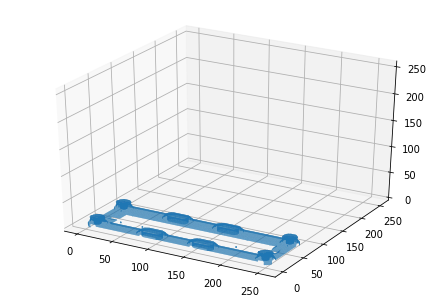

In [67]:
# we can save to STL
from data.stl import save_vectors_as_stl
from data.stl import plot_mesh


save_vectors_as_stl(verts[faces], 'stl_to_voxel_to_stl.stl')
plot_mesh(verts[faces])

In [ ]:
# it worked!

In [3]:
import numpy as np
a = np.load('../notebooks/_output/3d-vae-gan/model/epoch_0/epoch_0.npy')
a.shape

(1, 16, 16, 16, 1)